In [1]:
from quests_data import *

from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from scipy import integrate
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures


def moving_average_numpy(data, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(data, weights, mode='valid')

In [2]:
ROOT_PATH = "../data/A11-QTB"
dirs = sorted([
    d for d in os.listdir(ROOT_PATH)
    if os.path.isdir(f"{ROOT_PATH}/{d}") and not d.startswith(".")
])

In [3]:
results = []
for d in dirs:
    with open(f"{ROOT_PATH}/{d}/entropy.json", "r") as f:
        data = json.load(f)
    
#     temp, run = d.split("-")
    temp = int(d)
    
    results.append({
        "H": data["entropy"],
        "T": int(temp),
    })

df = pd.DataFrame(results).sort_values("T")
H = df["H"].values
T = df["T"].values

In [4]:
def fn(x, a, b):
    return a * (1 - np.exp(-b * x))

def debye_fn(y):
    return y**4 * np.exp(y) / (np.exp(y) - 1)**2

def debye_Cv(T, Td):
    t = T / Td
    Cv_int = integrate.quad(debye_fn, 1e-3, 1 / t)[0]
    Cv = 9 * np.power(t, 3) * Cv_int
    return Cv

def debye_entropy(T, Td, shift=1):
    _fn = lambda t: debye_Cv(t, Td) / t
    S = np.array([
        integrate.quad(_fn, 2, t)[0] for t in T
    ])
    return S + shift

params, _ = curve_fit(debye_entropy, T, H, p0=[600])

/var/folders/pk/bysbkx9j3993c_vqdsykcn680000gn/T/ipykernel_78399/936070542.py:5: RuntimeWarning: overflow encountered in scalar power
  return y**4 * np.exp(y) / (np.exp(y) - 1)**2


In [5]:
DEGREE = 2

def fit_cubic_lasso(x, y, degree=DEGREE, alpha=1.0):
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x.reshape(-1, 1))
    lasso = Lasso(alpha=alpha, max_iter=1000000)
    lasso.fit(x_poly, y)
    return lasso

def predict_lasso(x, lasso, degree=DEGREE):
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x.reshape(-1, 1))
    return lasso.predict(x_poly)

In [6]:
x = T[15:].reshape(-1, 1)
y = H[15:].reshape(-1)
lasso = fit_cubic_lasso(x, y)

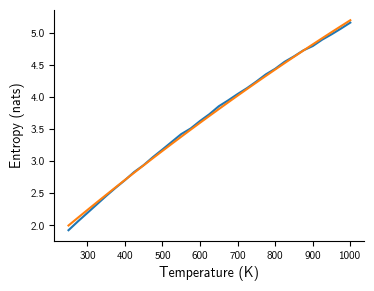

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(x, y, label="QUESTS")
ax.plot(x, predict_lasso(x, lasso), label="fit")


ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Entropy (nats)")

# savefig(fig, "01-debye.pdf")

plt.show()

/var/folders/pk/bysbkx9j3993c_vqdsykcn680000gn/T/ipykernel_78399/936070542.py:5: RuntimeWarning: overflow encountered in scalar power
  return y**4 * np.exp(y) / (np.exp(y) - 1)**2


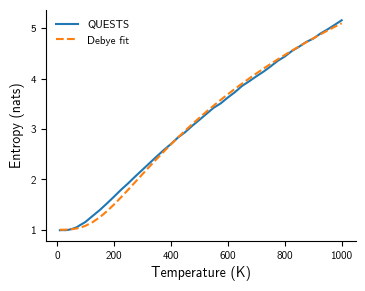

In [8]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(T, H, label="QUESTS")
ax.plot(T, debye_entropy(T, *params), "--", label="Debye fit")

ax.legend(frameon=False)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Entropy (nats)")

# savefig(fig, "01-debye.pdf")

plt.show()